In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
json_file_path = '/ghphi/data/phi/clean_test_results/labeled_test_results_3000.json'
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

FileNotFoundError: [Errno 2] No such file or directory: '/ghphi/data/phi/clean_test_results/labeled_test_results_3000.json'

In [51]:
path_txt =  '/ghphi/data/phi/page_classification_data/'
key_file_path = 'second3000_hierarchical_closest_key_file_names.txt'

with open(path_txt + key_file_path, 'r') as file:
    closest_key_file_names = [line.strip() for line in file]

# Print the array to verify the contents
print(len(closest_key_file_names))

923


In [52]:
test_keywords = ['biomarker findings', 'genomic findings', 'result','specimen', 'finding summary' , 'treatment strategies', 'areas of therapeutic use', 'supporting data', 'clinical trials', 'final diagnosis',
                 'therapies with clinical benefits', 'pathogen identification', 'gene expression', 'assessment', 'final report', 'specimen information', 'biomarker highlights' , 'method', 'biomarker results', 'clinical trials connector', \
                'tumor', 'variant', 'diagnostic', 'evidence']
# add in the label of guardant and filter out based on the results later on
company_test_list = ['FoundationOne Liquid', 'xF', 'xF+', 'Assure', 'Plasma Focus', 'Liquid Hallmark', 'Genestrat, InVisionFirst-Lung',
                     'FoundationOne CDx', 'Caris Molecular Intelligence', 'xT', 'OncoExtra', 'Altera', 'Invitae Cancer Screen', 'MyRisk', 'MyChoice']

In [53]:
# how to label it's test result or not: 
# label 1 if mention at least 1 company test in company_test_list, then find at least 1 match in test_keyword lists
# Process keywords and test list
processed_test_keywords = [re.sub(r'\s+', '', keyword.lower()) for keyword in test_keywords]
# Process company_test_list while preserving casing for specific words
processed_company_test_list = []

for test in company_test_list:
    if test.lower() in ['assure', 'xt', 'xf', 'xf+']:
        processed_company_test_list.append(re.sub(r'\s+', '', test))
    else:
        processed_company_test_list.append(re.sub(r'\s+', '', test.lower()))

In [54]:
print(processed_company_test_list)

['foundationoneliquid', 'xF', 'xF+', 'Assure', 'plasmafocus', 'liquidhallmark', 'genestrat,invisionfirst-lung', 'foundationonecdx', 'carismolecularintelligence', 'xT', 'oncoextra', 'altera', 'invitaecancerscreen', 'myrisk', 'mychoice']


In [55]:
# Function to check if a page contains at least one company test and one keyword from the test_keywords lists
def contains_test_and_keyword(page_content):
    for test in processed_company_test_list:
        if test not in ['xF', 'xF+', 'Assure', 'xT']:
            page_content = page_content.lower()
        if re.findall(r'\b{}\b'.format(re.escape(test)), page_content):
          for keyword in processed_test_keywords:
            if re.findall(r'\b{}\b'.format(re.escape(keyword)), page_content.lower()):
              return True
    return False

In [56]:
def preprocess_text(text):
    # Remove symbols and extra white spaces
    cleaned_text = re.sub(r'[^\w\s]', ' ', text)  # Remove symbols
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Replace multiple spaces with single space
    cleaned_text = cleaned_text.strip()  # Remove leading and trailing spaces
    return cleaned_text
    
def labeling_data(data):
    labeled_data = []
    for entry in data:
        file_name = entry['file_name']
        patient_id = entry['patient_id']
        page_content = preprocess_text(entry['page_content'])
        tests = entry['tests']
        # if no tests found, the page content must not contain any test result
        if len(tests)<1:
            label = 0 
        else: 
            if contains_test_and_keyword(page_content):
                label = 1
            # not belong to compeytitor's test results if not in the clustering key files 
            else: 
                label = 0         
        labeled_data.append({'file_name': file_name, 'patient_id': patient_id, 'page_content': page_content, 'label': label})
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(labeled_data)
    return df

def splitting_data(df):
    # Splitting into train, validation, and test sets using StratifiedShuffleSplit
    sss_train = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

    # Stratified splitting for training set
    for train_index, temp_index in sss_train.split(df, df['label']):
        train_df = df.iloc[train_index].copy()
        temp_df = df.iloc[temp_index].copy()

    # Stratified splitting for validation and test sets from the temp_df
    for val_index, test_index in sss_val_test.split(temp_df, temp_df['label']):
        val_df = temp_df.iloc[val_index].copy()
        test_df = temp_df.iloc[test_index].copy()

    # Reset index for each DataFrame
    train_df.reset_index(drop=True, inplace=True)
    val_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)

    # Print the number of samples in each set
    print("Train set size:", len(train_df))
    print("Validation set size:", len(val_df))
    print("Test set size:", len(test_df))
    
    return train_df, val_df, test_df

In [57]:
df_labeled = labeling_data(data)
train_df, val_df, test_df = splitting_data(df_labeled)

Train set size: 1520
Validation set size: 326
Test set size: 326


In [58]:
train_df.head()

,file_name,patient_id,page_content,label
0,A0569166_MedRec1/image-026.txt,A0569166,2022 11 29 11 11 53 29 47 REDACTED REDACTED My...,1
1,A0273290_MedRec2/image-033.txt,A0273290,01 05 2022 3 51 51 PM PAGE 37 OF 45 REDACTED R...,0
2,A83264/image-014.txt,A83264,O1 26 718 11 12 FROM CBSN Tenaya 7027493 708 T...,0
3,A0588576_MedRec1/image-082.txt,A0588576,To 18772418203 Paae 085 of 108 2022 12 01 18 3...,1
4,A0340486/image-005.txt,A0340486,To 16173942606 Page 04 of 12 2021 03 31 00 38 ...,0


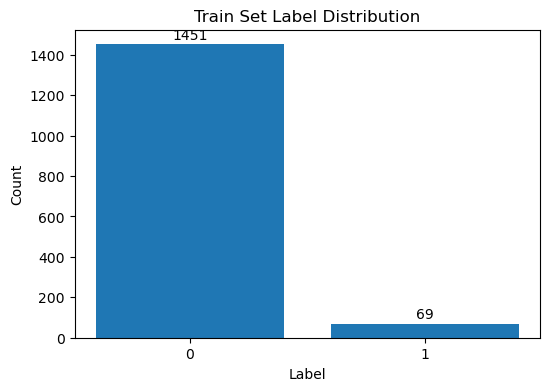

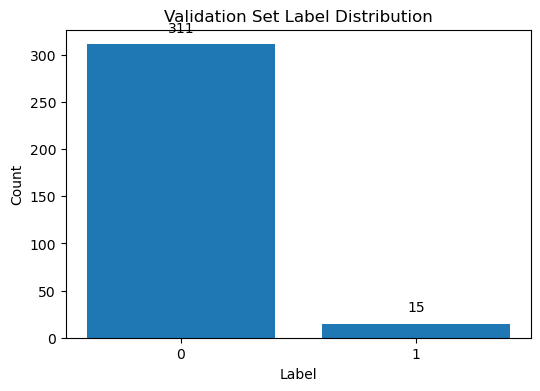

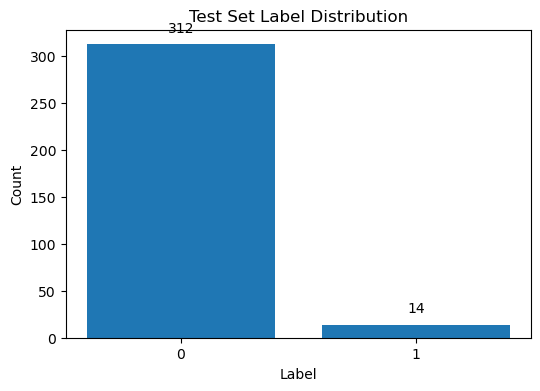

In [59]:
def plot_label_distribution(df, title):
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(6, 4))
    bars = plt.bar(label_counts.index.astype(str), label_counts.values)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(title)

    # Display label counts on the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, ha='center', va='bottom')

    plt.show()

# Plot label distributions for train, validation, and test sets
plot_label_distribution(train_df, 'Train Set Label Distribution')
plot_label_distribution(val_df, 'Validation Set Label Distribution')
plot_label_distribution(test_df, 'Test Set Label Distribution')

In [60]:
save_dir = '/ghphi/data/phi/page_classification_data/'
train_df.to_csv(save_dir+"train_docs_sm.csv", index=False)
val_df.to_csv(save_dir+"valid_docs_sm.csv", index=False)
test_df.to_csv(save_dir+"test_docs_sm.csv", index=False)

In [61]:
# verify with clusteirng
# Gather filenames from train_df, val_df, and test_df with label 1
def labeling_verification(train_df, val_df, test_df):
    label_1_filenames = train_df[train_df['label'] == 1]['file_name'].tolist() + \
                        val_df[val_df['label'] == 1]['file_name'].tolist() + \
                        test_df[test_df['label'] == 1]['file_name'].tolist()
    
    # Count the number of matches in closest_key_file_names
    matching_filenames = [filename for filename in label_1_filenames if filename in closest_key_file_names]
    num_matches = len(matching_filenames)
    total_label_1_files = len(label_1_filenames)
    
    # Calculate the percentage
    percentage_matches = (num_matches / total_label_1_files) * 100 if total_label_1_files > 0 else 0
    
    print("Number of matching filenames:", num_matches)
    print("Total number of label 1 files:", total_label_1_files)
    print("Percentage of matches:", percentage_matches)


In [62]:
labeling_verification(train_df, val_df, test_df)

Number of matching filenames: 61
Total number of label 1 files: 98
Percentage of matches: 62.244897959183675


In [63]:
pwd

'/ghdevhome/home/cpan/notebooks/models'